In [16]:
import numpy as np
import pandas as pd
import scipy.special 
import matplotlib.pyplot as plt 
from math import *

In [17]:
def euro_binomial_model(S, K, T, r, q, sigma, N, flag = 'c') -> float:
    ''' Binomial model calculating the price of European call and put options.

    Keyword arguments: 
    S -- Stock price at time zero
    K -- Option exercise price 
    T -- Time to maturity (in years)
    r -- Continuously compounded annual interest rate
    q -- Annual continuous dividend yield
    sigma -- Volatility
    N -- Number of steps in a binomial tree
    flag -- 'c' for call and 'p' for put (default = call) 
    '''
    dt = T/N # Length of binomial period in years
    u = np.exp((r - q) * dt + sigma * np.sqrt(dt))
    d = np.exp((r - q) * dt - sigma * np.sqrt(dt))
    p = (np.exp((r - q) * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    if flag == 'c':
        z = 1
    else:
        z = -1 

    # Arrays for storing option and stock prices
    option_prices = np.zeros((N + 1, N + 1))
    stock_prices = np.zeros((N + 1, N + 1))
    # Initialize the stock prices and option prices at maturities
    stock_maturity_prices = S * d ** (np.arange(N, -1, -1)) * u ** (np.arange(0, N + 1, 1))
    stock_prices[:, -1] = stock_maturity_prices
    option_maturity_prices = np.maximum(z * (stock_prices[:, -1] - K), np.zeros(N + 1))
    option_prices[:, -1] = option_maturity_prices
    
    # Recursively calculating option price from option maturity prices
    for i in np.arange(N, 0, -1):
        up_vector = np.concatenate(((option_prices[:, i][1: i + 1], np.zeros((N - i) + 1))))
        down_vector = np.concatenate((option_prices[:, i][0: i], np.zeros((N - i) + 1)))
        stock_price = S * d ** (np.arange(i - 1 , -1, -1)) * u ** (np.arange(0, i, 1))
        stock_prices[:, i - 1] = np.concatenate((stock_price, np.zeros((N - i + 1))))
        option_prices[:, i - 1] = discount * (p * up_vector 
                                            + (1 - p) * down_vector)
    return option_prices[0][0]


In [18]:
res = euro_binomial_model(100, 100, 3, 0.04, 0.02, 0.20, 100, 'p')
res
print('Price of option: ', "{:.2f}".format(res), '$')

Price of option:  10.01 $


In [19]:
n_periods = 100
prices = []

for i in range(0, n_periods):
    price = euro_binomial_model(100, 100, 3, 0.04, 0.02, 0.20, i + 1, 'p')
    prices.append(price)

prices = np.array(prices)

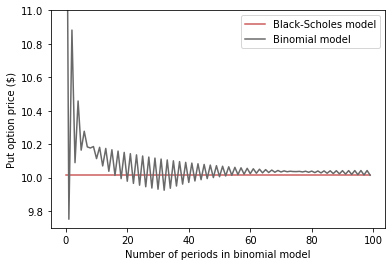

In [20]:
d = {'Black-Scholes model': [10.017080535490749 for n in range(n_periods)],
    'Binomial model': prices}
df = pd.DataFrame(d)
df.plot(color = ['indianred', 'dimgray'])
plt.xlabel('Number of periods in binomial model')
plt.ylabel('Put option price ($)')
plt.ylim(9.7,11)
plt.savefig('european_binomial_put.pdf')
plt.show()

In [21]:
res = euro_binomial_model(100, 100, 3, 0.04, 0.02, 0.20, 100, 'c')
res
print('Price of option: ', "{:.2f}".format(res), '$')

Price of option:  15.50 $


In [22]:
n_periods = 100
prices = []

for i in range(0, n_periods):
    price = euro_binomial_model(100, 100, 3, 0.04, 0.02, 0.20, i + 1, 'c')
    prices.append(price)

prices = np.array(prices)

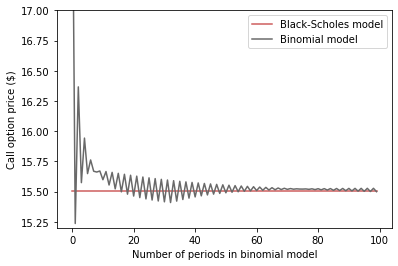

In [23]:
d = {'Black-Scholes model': [15.501490222199855 for n in range(n_periods)],
    'Binomial model': prices}
df = pd.DataFrame(d)
df.plot(color = ['indianred', 'dimgray'])
plt.xlabel('Number of periods in binomial model')
plt.ylabel('Call option price ($)')
plt.ylim(15.2,17)
plt.savefig('european_binomial_call.pdf')
plt.show()

In [24]:
def path_number(j, i) -> float:
    ''' Number of ways reaching node (j, i) in a binomial tree.

    j -- Number of time steps to a node
    i -- Number of times the asset price has gone up to reach node
    '''
    return scipy.special.factorial(j) / (scipy.special.factorial(i)
                                  * scipy.special.factorial(j - i))

def path_probability(j, i, p) -> float:
    ''' Probability of reaching node (j, i) in a binomial tree.

    j -- Number of time steps to a node
    i -- Number of times the asset price has gone up to reach node
    p -- Risk neutral probability of going up in a binomial tree
    '''
    return path_number(j, i) * (p ** i) * (1 - p) ** (j - i) 
        

def hit_probability(S, S_t, T, sigma, H) -> float:
    ''' Probability of hitting barrier
        (The Complete Guide to Option Pricing Formulas, p. 306, Haug 2006).
    
    S -- Stock price at time zero
    S_t -- Stock price at time T
    T -- Time to maturity
    sigma -- Volatility
    H -- Barrier
    '''
    return np.exp((-2 / ((sigma**2) * T) ) * np.abs(np.log(S / H) * np.log(S_t / H)))

In [25]:
def euro_binomial_knock_in(S, K, T, r, q, sigma, N, H, flag = 'c') -> float:
    ''' Binomial model calculating the price of European call and put knock in options.
        Base on computer algorithm "Binomial Bridge Barrier" (Haug, 2006, p.307)
    

    Keyword arguments: 
    S -- Stock price at time zero
    K -- Option exercise price 
    T -- Time to maturity (in years)
    r -- Continuously compounded annual interest rate
    q -- Annual continuous dividend yield
    sigma -- Volatility
    N -- Number of steps in a binomial tree
    H -- Barrier
    flag -- 'c' for call and 'p' for put (default = call) 
    '''
    dt = T/N # Length of binomial period in years
    u = np.exp((r - q) * dt + sigma * np.sqrt(dt))
    d = np.exp((r - q) * dt - sigma * np.sqrt(dt))
    p = (np.exp((r - q) * dt) - d) / (u - d)
    discount = np.exp(-r * T)

    if flag == 'c':
        z = 1
    else:
        z = -1 

    stock_maturity_prices = S * d ** (np.arange(N, -1, -1)) * u ** (np.arange(0, N + 1, 1))
    if (S < H):
        barrier_hit_probability = np.where(stock_maturity_prices < H,
                                            hit_probability(S, stock_maturity_prices, T, sigma, H), 1)
    else:
        barrier_hit_probability = np.where(stock_maturity_prices >= H,
                                            hit_probability(S, stock_maturity_prices, T, sigma, H), 1)
    path_prob = path_probability(np.array([N] * (N + 1)), np.arange(N + 1), p)
    option_value = (np.sum((barrier_hit_probability) * path_prob * np.maximum(
                                        z * (stock_maturity_prices - K), 0), axis = 0)) * discount

    return option_value

In [36]:
res = euro_binomial_knock_in(100, 100, 3, 0.04, 0.02, 0.20, 123, 150, 'c')
print('Price of option: ', "{:.2f}".format(res), '$')

Price of option:  11.70 $


In [37]:
def euro_binomial_knock_out(S, K, T, r, q, sigma, N, H, flag = 'c') -> float:
    ''' Binomial model calculating the price of European call and put knock out options.
        Base on computer algorithm "Binomial Bridge Barrier" (Haug, 2006, p.307)

    Keyword arguments: 
    S -- Stock price at time zero
    K -- Option exercise price 
    T -- Time to maturity (in years)
    r -- Continuously compounded annual interest rate
    q -- Annual continuous dividend yield
    sigma -- Volatility
    N -- Number of steps in a binomial tree
    H -- Barrier
    flag -- 'c' for call and 'p' for put (default = call) 
    '''
    dt = T/N # Length of binomial period in years
    u = np.exp((r - q) * dt + sigma * np.sqrt(dt))
    d = np.exp((r - q) * dt - sigma * np.sqrt(dt))
    p = (np.exp((r - q) * dt) - d) / (u - d)
    discount = np.exp(-r * T)

    if flag == 'c':
        z = 1
    else:
        z = -1 

    stock_maturity_prices = S * d ** (np.arange(N, -1, -1)) * u ** (np.arange(0, N + 1, 1))
    if (S < H):
        barrier_hit_probability = np.where(stock_maturity_prices < H,
                                            hit_probability(S, stock_maturity_prices, T, sigma, H), 1)
    else:
        barrier_hit_probability = np.where(stock_maturity_prices >= H,
                                            hit_probability(S, stock_maturity_prices, T, sigma, H), 1)
    path_prob = path_probability(np.array([N] * (N + 1)), np.arange(N + 1), p)
    option_value = (np.sum((1 - barrier_hit_probability) * path_prob * np.maximum(
                                        z * (stock_maturity_prices - K), 0), axis = 0)) * discount

    return option_value

In [38]:
res = euro_binomial_knock_out(100, 100, 3, 0.04, 0.02, 0.20, 123, 150, 'c')
print('Price of option: ', "{:.2f}".format(res), '$')

Price of option:  3.82 $


In [39]:
n_periods = 123
prices = []

for i in range(0, n_periods):
    price = euro_binomial_knock_out(100, 100, 3, 0.04, 0.02, 0.20, i + 1, 150, 'p')
    prices.append(price)

prices = np.array(prices)

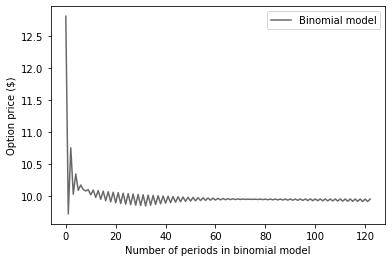

In [40]:
d = {'Binomial model': prices}
df = pd.DataFrame(d)
df.plot(color = ['dimgray'])
plt.xlabel('Number of periods in binomial model')
plt.ylabel('Option price ($)')
plt.show()